In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
from model import Net
from training import train,test, train_losses, train_acc, test_losses, test_acc

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA Available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS Available")
else:
    device = torch.device("cpu")
    print("Using CPU")

MPS Available


In [3]:
train_transforms = transforms.Compose([
                        transforms.RandomAffine(degrees=7, translate=(0.08, 0.08)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                        # ,transforms.RandomErasing(p=0.05, scale=(0.02, 0.05), ratio=(0.3, 3.3))  # tiny, optional
                        ])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:20<00:00, 473kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 70.5kB/s]
100%|██████████| 1.65M/1.65M [00:09<00:00, 175kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.60MB/s]


In [5]:
batch_size = 128
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


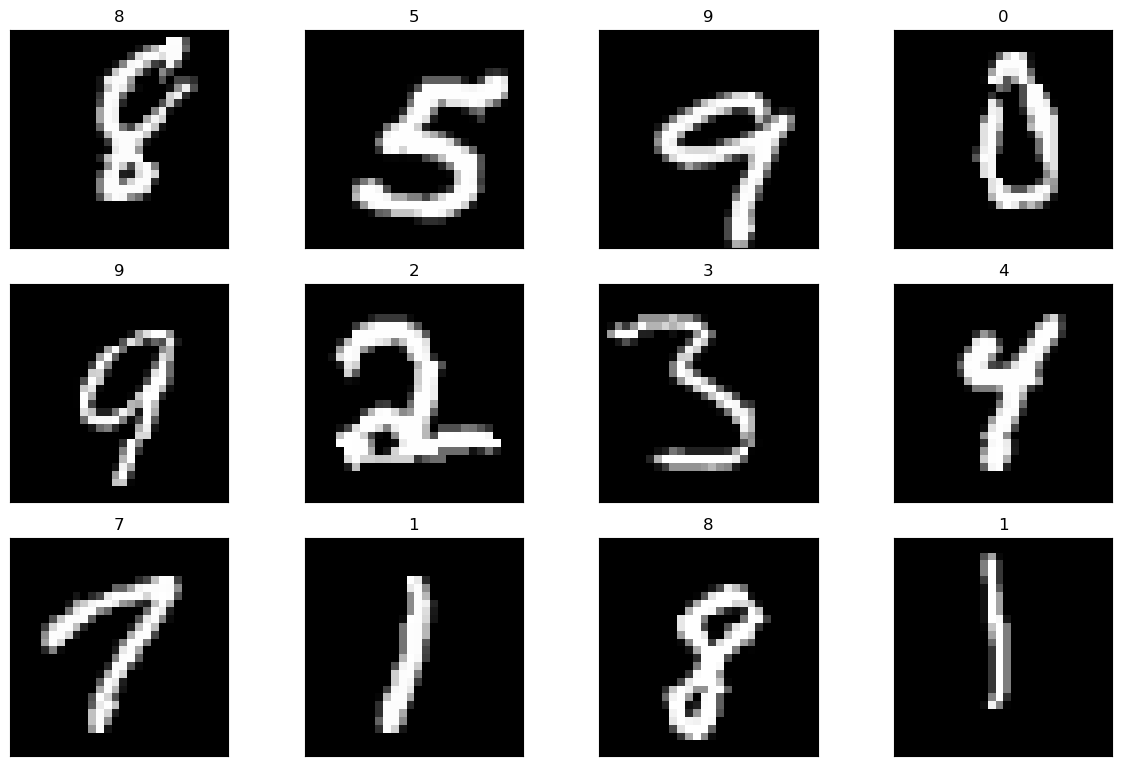

In [6]:
def visualize_batch():
    batch_data, batch_label = next(iter(train_loader))
    fig = plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])
    plt.show()

visualize_batch()

In [7]:
model = Net().to(device)  # Using improved model
total_params = model.count_parameters()
print(f"\nModel Parameters: {total_params:,}")
print(f"Model Architecture:")
print(model)
print("="*50 + "\n")

# Use AdamW for better regularization with small models
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0)
print(f"Optimizer: SGD (lr=0.001, weight_decay=0)")


criterion = nn.CrossEntropyLoss(label_smoothing=0.02)
num_epochs = 20
# scheduler = OneCycleLR(
#     optimizer,
#     max_lr=0.05,                        # try 0.008–0.02; 0.01 is a good start
#     epochs=num_epochs,
#     steps_per_epoch=len(train_loader),
#     pct_start=0.2,                      # warmup portion
#     div_factor=10, final_div_factor=100
#     ,anneal_strategy="cos"
# )



print(f"Loss: CrossEntropyLoss")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Training Samples: {len(train_data):,}")
print(f"Test Samples: {len(test_data):,}")
print("="*60 + "\n")

# Training loop
print("Starting training...")
best_test_acc = 0

for epoch in range(1, num_epochs+1):
    # Train
    train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)

    # Test
    test_accuracy = test(model, device, test_loader, criterion)


Model Parameters: 7,784
Model Architecture:
Net(
  (conv1): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(7, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(10, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 1:
  Accuracy: 6294/60000 (10.49%)
  Avg Loss: 2.2837
Test Results:
  Accuracy: 1672/10000 (16.72%)
  Avg Loss: 2.1721


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 2:
  Accuracy: 14203/60000 (23.67%)
  Avg Loss: 2.1224
Test Results:
  Accuracy: 3907/10000 (39.07%)
  Avg Loss: 2.0092


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 3:
  Accuracy: 23800/60000 (39.67%)
  Avg Loss: 2.0002
Test Results:
  Accuracy: 5764/10000 (57.64%)
  Avg Loss: 1.8864


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 4:
  Accuracy: 31550/60000 (52.58%)
  Avg Loss: 1.8973
Test Results:
  Accuracy: 6493/10000 (64.93%)
  Avg Loss: 1.7728


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 5:
  Accuracy: 34919/60000 (58.20%)
  Avg Loss: 1.7971
Test Results:
  Accuracy: 6619/10000 (66.19%)
  Avg Loss: 1.6493


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 6:
  Accuracy: 36496/60000 (60.83%)
  Avg Loss: 1.6975
Test Results:
  Accuracy: 6783/10000 (67.83%)
  Avg Loss: 1.5395


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 7:
  Accuracy: 37989/60000 (63.31%)
  Avg Loss: 1.5981
Test Results:
  Accuracy: 7024/10000 (70.24%)
  Avg Loss: 1.4271


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 8:
  Accuracy: 39541/60000 (65.90%)
  Avg Loss: 1.5010
Test Results:
  Accuracy: 7233/10000 (72.33%)
  Avg Loss: 1.3301


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 9:
  Accuracy: 41240/60000 (68.73%)
  Avg Loss: 1.4079
Test Results:
  Accuracy: 7475/10000 (74.75%)
  Avg Loss: 1.2339


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 10:
  Accuracy: 42641/60000 (71.07%)
  Avg Loss: 1.3208
Test Results:
  Accuracy: 7728/10000 (77.28%)
  Avg Loss: 1.1494


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 11:
  Accuracy: 44055/60000 (73.42%)
  Avg Loss: 1.2349
Test Results:
  Accuracy: 7964/10000 (79.64%)
  Avg Loss: 1.0564


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 12:
  Accuracy: 45358/60000 (75.60%)
  Avg Loss: 1.1517
Test Results:
  Accuracy: 8204/10000 (82.04%)
  Avg Loss: 0.9710


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 13:
  Accuracy: 46567/60000 (77.61%)
  Avg Loss: 1.0757
Test Results:
  Accuracy: 8394/10000 (83.94%)
  Avg Loss: 0.8937


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 14:
  Accuracy: 47803/60000 (79.67%)
  Avg Loss: 1.0071
Test Results:
  Accuracy: 8561/10000 (85.61%)
  Avg Loss: 0.8320


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 15:
  Accuracy: 48830/60000 (81.38%)
  Avg Loss: 0.9428
Test Results:
  Accuracy: 8759/10000 (87.59%)
  Avg Loss: 0.7729


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 16:
  Accuracy: 49944/60000 (83.24%)
  Avg Loss: 0.8840
Test Results:
  Accuracy: 8942/10000 (89.42%)
  Avg Loss: 0.7138


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 17:
  Accuracy: 51094/60000 (85.16%)
  Avg Loss: 0.8295
Test Results:
  Accuracy: 9114/10000 (91.14%)
  Avg Loss: 0.6571


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 18:
  Accuracy: 52032/60000 (86.72%)
  Avg Loss: 0.7778
Test Results:
  Accuracy: 9293/10000 (92.93%)
  Avg Loss: 0.6105


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 19:
  Accuracy: 53100/60000 (88.50%)
  Avg Loss: 0.7280
Test Results:
  Accuracy: 9364/10000 (93.64%)
  Avg Loss: 0.5592


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 20:
  Accuracy: 53854/60000 (89.76%)
  Avg Loss: 0.6811
Test Results:
  Accuracy: 9447/10000 (94.47%)
  Avg Loss: 0.5170


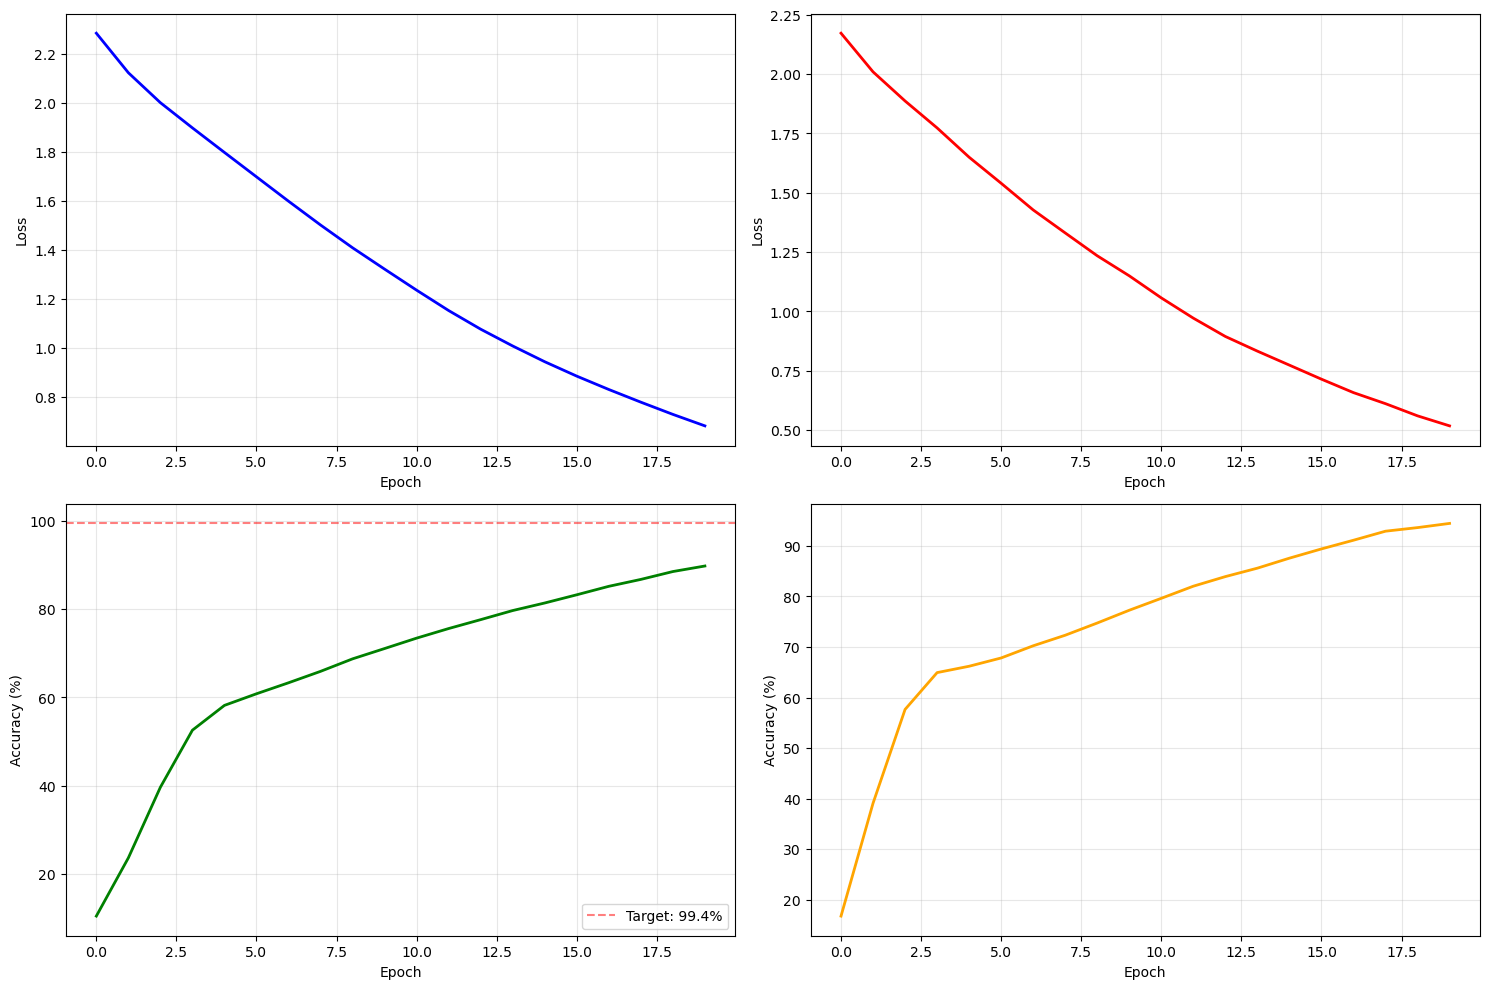


Model Parameters: 7,784 (< 25,000 ✓)
Final Training Accuracy: 89.76%
Final Test Accuracy: 94.47%
Best Test Accuracy: 0.00%
First Epoch Training Accuracy: 10.49%

⚠ First epoch accuracy was 10.49% (target was 99.4%)
  Tips to improve:
  - Try the LightweightNet or UltraLightNet models
  - Increase learning rate slightly
  - Use smaller batch size for more updates


In [8]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
axs[0, 0].plot(train_losses, 'b-', linewidth=2)
#axs[0, 0].set_title(f"Training Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axs[1, 0].plot(train_acc, 'g-', linewidth=2)
#axs[1, 0].set_title(f"Training Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].axhline(y=99.4, color='r', linestyle='--', alpha=0.5, label='Target: 99.4%')
axs[1, 0].legend()

# Test Loss
axs[0, 1].plot(test_losses, 'r-', linewidth=2)
#axs[0, 1].set_title(f"Test Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True, alpha=0.3)

# Test Accuracy
axs[1, 1].plot(test_acc, 'orange', linewidth=2)
#axs[1, 1].set_title(f"Test Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")
axs[1, 1].grid(True, alpha=0.3)

#plt.suptitle(f"Training Results - {model_name} ({total_params:,} parameters)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final summary
print(f"\n{'='*60}")
#print(f"FINAL SUMMARY - {model_name}")
print(f"{'='*60}")
print(f"Model Parameters: {total_params:,} (< 25,000 ✓)")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"First Epoch Training Accuracy: {train_acc[0]:.2f}%")

if train_acc[0] >= 99.4:
    print(f"\n✓ SUCCESS: Achieved {train_acc[0]:.2f}% training accuracy in first epoch!")
else:
    print(f"\n⚠ First epoch accuracy was {train_acc[0]:.2f}% (target was 99.4%)")
    print("  Tips to improve:")
    print("  - Try the LightweightNet or UltraLightNet models")
    print("  - Increase learning rate slightly")
    print("  - Use smaller batch size for more updates")

print(f"{'='*60}")